In [1]:
import os
import numpy as np
import argparse


import pandas as pd
from sklearn.decomposition import PCA
from operator import itemgetter
import random
import matplotlib.pyplot as plt
import umap.umap_ as umap
import time

import torch
from spiral.main import SPIRAL_integration
from spiral.layers import *
from spiral.utils import *
from spiral.CoordAlignment import CoordAlignment
from sklearn.metrics.pairwise import euclidean_distances
R_dirs="/home/tguo/tguo2/miniconda3/envs/stnet/lib/R"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

step1: SPIRAL integration

In [2]:
dirs="/data02/tguo/space_batch_effect/mouse_OB/"
samples=["BGI","SlideV2"]
extra_dirs="BGI_SlideV2_10X/"
# samples=['Stereo_bin34','SlideV2']
# extra_dirs="Stereo-bin34-filter/"
SEP=','
net_cate='_KNN_'
knn=8

N_WALKS=knn
WALK_LEN=1
N_WALK_LEN=knn
NUM_NEG=knn


feat_file=[]
edge_file=[]
meta_file=[]
coord_file=[]
flags=''
for i in range(len(samples)):
    feat_file.append(dirs+"gtt_input/"+extra_dirs+str(samples[i])+"_mat.csv")
    edge_file.append(dirs+"gtt_input/"+extra_dirs+str(samples[i])+"_edge"+net_cate+str(knn)+".csv")
    meta_file.append(dirs+"gtt_input/"+extra_dirs+str(samples[i])+"_meta.csv")
    coord_file.append(dirs+"gtt_input/"+extra_dirs+str(samples[i])+"_coord.csv")
    flags=flags+'_'+samples[i]
N=pd.read_csv(feat_file[0],header=0,index_col=0).shape[1]
if (len(samples)==2):
    M=1
else:
    M=len(samples)

In [3]:
parser = argparse.ArgumentParser()

parser.add_argument('--seed', type=int, default=0, help='The seed of initialization.')
parser.add_argument('--AEdims', type=list, default=[N,[512],32], help='Dim of encoder.')
parser.add_argument('--AEdimsR', type=list, default=[32,[512],N], help='Dim of decoder.')
parser.add_argument('--GSdims', type=list, default=[512,32], help='Dim of GraphSAGE.')
parser.add_argument('--zdim', type=int, default=32, help='Dim of embedding.')
parser.add_argument('--znoise_dim', type=int, default=4, help='Dim of noise embedding.')
parser.add_argument('--CLdims', type=list, default=[4,[],M], help='Dim of classifier.')
parser.add_argument('--DIdims', type=list, default=[28,[32,16],M], help='Dim of discriminator.')
parser.add_argument('--beta', type=float, default=1.0, help='weight of GraphSAGE.')
parser.add_argument('--agg_class', type=str, default=MeanAggregator, help='Function of aggregator.')
parser.add_argument('--num_samples', type=int, default=20, help='number of neighbors to sample.')

parser.add_argument('--N_WALKS', type=int, default=N_WALKS, help='number of walks of random work for postive pairs.')
parser.add_argument('--WALK_LEN', type=int, default=WALK_LEN, help='walk length of random work for postive pairs.')
parser.add_argument('--N_WALK_LEN', type=int, default=N_WALK_LEN, help='number of walks of random work for negative pairs.')
parser.add_argument('--NUM_NEG', type=int, default=NUM_NEG, help='number of negative pairs.')

parser.add_argument('--epochs', type=int, default=100, help='Number of epochs to train.')
parser.add_argument('--batch_size', type=int, default=512, help='Size of batches to train.')
parser.add_argument('--lr', type=float, default=1e-3, help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=5e-4, help='Weight decay.')
parser.add_argument('--alpha1', type=float, default=N, help='Weight of decoder loss.')
parser.add_argument('--alpha2', type=float, default=1, help='Weight of GraphSAGE loss.')
parser.add_argument('--alpha3', type=float, default=1, help='Weight of classifier loss.')
parser.add_argument('--alpha4', type=float, default=1, help='Weight of discriminator loss.')
parser.add_argument('--lamda', type=float, default=1, help='Weight of GRL.') #####Stereo-seq:35um resolution 
# parser.add_argument('--lamda', type=float, default=0.1, help='Weight of GRL.')######Stereo-seq: 25um resolution
parser.add_argument('--Q', type=float, default=10, help='Weight negative loss for sage losss.')

params,unknown=parser.parse_known_args()

In [4]:
SPII=SPIRAL_integration(params,feat_file,edge_file,meta_file)

In [5]:
SPII.train()
if not os.path.exists(dirs+"model/"):
    os.makedirs(dirs+"model/")
# torch.save(SPII.model.state_dict(),dirs+"model/SPIRAL"+flags+"_model_"+str(SPII.params.batch_size)+".pt")

--------------------------------
Training.
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 1338.40474/0.24005/9.57550/0.44527/0.66506
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 479.79368/0.08488/9.64836/0.24782/0.39867
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 451.47385/0.07977/9.73116/0.20711/0.32028
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 442.22849/0.07810/9.79725/0.20863/0.26555
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 432.68624/0.07642/9.60362/0.20851/0.21537
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 428.73310/0.07571/9.58204/0.20877/0.17864
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 426.08715/0.07525/9.53243/0.20620/0.14504
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 424.99616/0.07505/9.55684/0.20090/0.11405
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 420.52125/0.07428/9.38150/0.19969/0.09259
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 423.02782/0.07471/9.53468/0.20149/0.07520
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 422.6982

total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 381.35344/0.06862/1.16687/0.09633/0.52933
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 382.22793/0.06878/1.17043/0.09643/0.53067
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 381.92605/0.06873/1.16629/0.09347/0.52700
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 381.18755/0.06860/1.16622/0.09377/0.52828
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 382.17075/0.06877/1.16788/0.09301/0.52955
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 381.10652/0.06858/1.16557/0.09148/0.52740
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 383.86474/0.06908/1.17471/0.09209/0.53224
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 380.17010/0.06841/1.16259/0.09141/0.52838
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 382.64633/0.06886/1.17015/0.09111/0.52822


In [6]:
SPII.model.eval()
all_idx=np.arange(SPII.feat.shape[0])
all_layer,all_mapping=layer_map(all_idx.tolist(),SPII.adj,len(SPII.params.GSdims))
all_rows=SPII.adj.tolil().rows[all_layer[0]]
all_feature=torch.Tensor(SPII.feat.iloc[all_layer[0],:].values).float().cuda()
all_embed,ae_out,clas_out,disc_out=SPII.model(all_feature,all_layer,all_mapping,all_rows,SPII.params.lamda,SPII.de_act,SPII.cl_act)
[ae_embed,gs_embed,embed]=all_embed
[x_bar,x]=ae_out
embed=embed.cpu().detach()
embed=embed[:,SPII.params.znoise_dim:]
names=['GTT_'+str(i) for i in range(embed.shape[1])]
embed1=pd.DataFrame(np.array(embed),index=SPII.feat.index,columns=names)
if not os.path.exists(dirs+"gtt_output/"):
    os.makedirs(dirs+"gtt_output/")

embed_file=dirs+"gtt_output/SPIRAL"+flags+"_embed_"+str(SPII.params.batch_size)+".csv"
embed1.to_csv(embed_file)

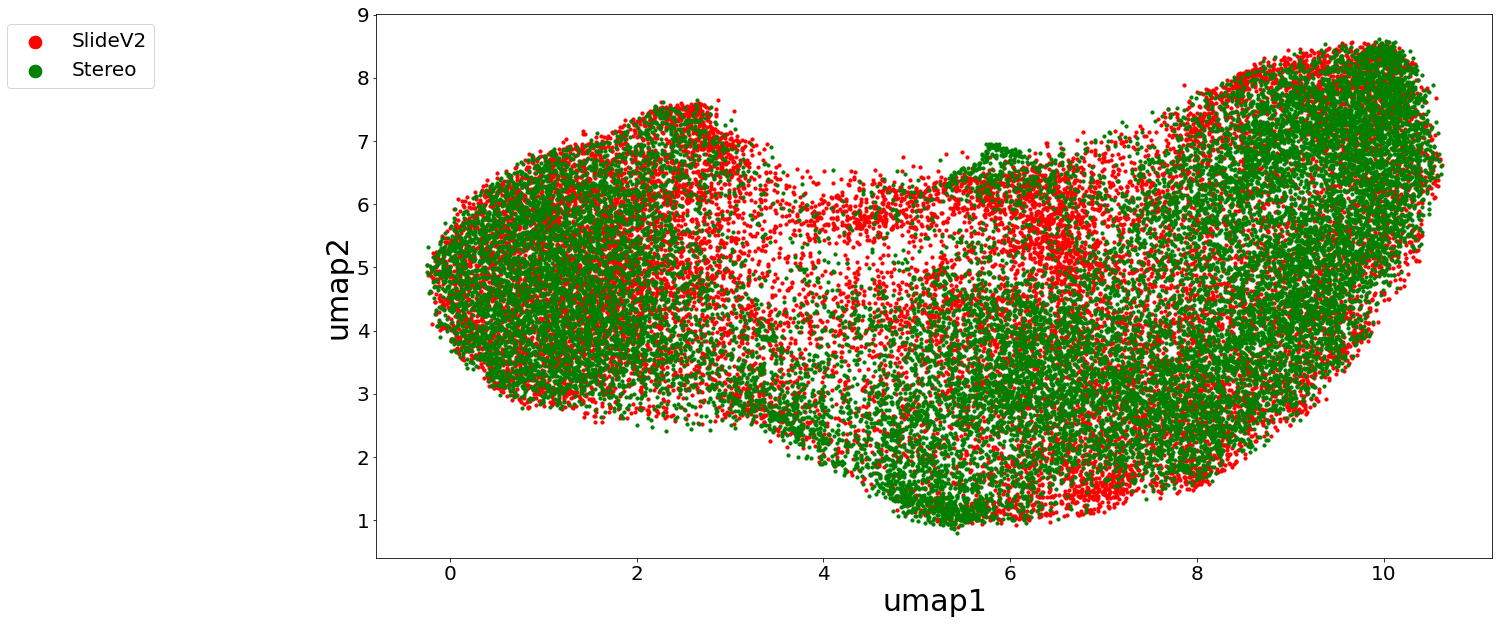

In [13]:
batch=SPII.meta.loc[:,'batch']
ub=np.unique(batch)
import umap.umap_ as umap
import matplotlib.pyplot as plt
umap_mat=umap.UMAP().fit_transform(embed)
colour2=['r','g','black','cyan','blue','purple','yellow','grey']
colour1=['lightcoral','red','tomato','chocolate','darkorange','gold','olive','yellow','yellowgreen','lawngreen','forestgreen','lime',
       'cyan','deepskyblue','dodgerblue','royalblue','blue','blueviolet','purple','fuchsia','hotpink','pink','gray','black','teal']
f, axs= plt.subplots(1,1,figsize=(20,10))
size=10
for i in range(len(ub)):
    axs.scatter(umap_mat[np.where(batch==ub[i])[0],0],umap_mat[np.where(batch==ub[i])[0],1],c=colour2[i],s=size)

axs.set_xlabel("umap1",fontsize=30)
axs.set_ylabel("umap2",fontsize=30)
axs.legend(ub,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(-0.19,1))
axs.tick_params(axis='both', which='major', labelsize=20)


step2: clustering by seurat_clustering.ipynb

In [8]:
cluster_file=dirs+"metrics/spiral"+flags+"_seuratmethod_clust.csv"

In [9]:
import anndata
import scanpy as sc
adata=anndata.AnnData(SPII.feat)
adata.obsm['spiral']=embed1.values
adata.obs['batch']=SPII.meta.loc[:,'batch'].values

coord=pd.read_csv(coord_file[0],header=0,index_col=0)
for i in np.arange(1,len(samples)):
    coord=pd.concat((coord,pd.read_csv(coord_file[i],header=0,index_col=0)))
    
adata.obsm['spatial']=coord.loc[adata.obs_names,:].values
cluster=pd.read_csv(cluster_file,header=0,index_col=0)
adata.obs['SPIRAL']=cluster.loc[adata.obs_names,:]

step3: smooth clusters

In [10]:
from smooting_clustering import refine

adata.obs['SPIRAL_refine']=adata.obs['SPIRAL']
ub=np.unique(adata.obs['batch'])
for i in range(len(ub)):
    idx=np.where(adata.obs['batch']==ub[i])[0]
    ann1=adata[idx,:]
    sample_id=ann1.obs_names
    pred=ann1.obs['SPIRAL']
    dis=euclidean_distances(ann1.obsm['spatial'],ann1.obsm['spatial'])
    refined_pred=refine(sample_id, pred, dis, num_nbs=knn)
    adata.obs['SPIRAL_refine'][idx]=refined_pred
    
# cluster_file_save=dirs+"metrics/spiral"+flags+"_seuratmethod_clust_modify.csv"
# pd.DataFrame(adata.obs['SPIRAL_refine']).to_csv(cluster_file_save)

/home/tguo/tguo2/miniconda3/envs/stnet/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/tguo/tguo2/miniconda3/envs/stnet/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


/home/tguo/tguo2/miniconda3/envs/stnet/lib/python3.6/site-packages/anndata/_core/anndata.py:1237: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'batch' as categorical


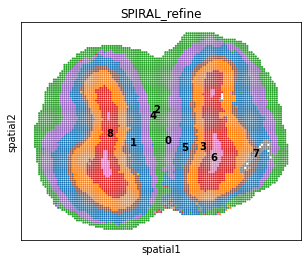

Trying to set attribute `.obs` of view, copying.
... storing 'batch' as categorical


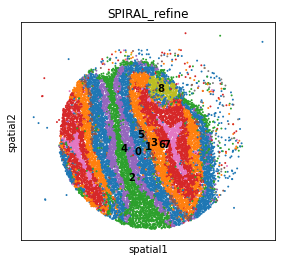

In [12]:
adata.obs['SPIRAL_refine']=adata.obs['SPIRAL_refine'].astype('category')
size1=1
size2=50
metric='SPIRAL_refine'
adata1=adata[adata.obs['batch']==ub[0],:]
sc.pl.spatial(adata1,color=metric, spot_size=size1,legend_loc='on data')
adata1=adata[adata.obs['batch']==ub[1],:]
sc.pl.spatial(adata1,color=metric, spot_size=size2,legend_loc='on data')


step4: spiral alignment   (embed_file and cluster_file)

In [14]:
clust_cate='seuratmethod'
input_file=[meta_file,coord_file,embed_file,cluster_file]
output_dirs=dirs+"gtt_output/SPIRAL_alignment/"
if not os.path.exists(output_dirs):
    os.makedirs(output_dirs)
# ub=np.unique(adata.obs['batch'])
ub=['BGI','SlideV2']

In [15]:
alpha=0.5
types="weighted_mean"
clust_cate="seuratmethod"
R_dirs="/home/tguo/tguo2/miniconda3/envs/stnet/lib/R"
CA=CoordAlignment(input_file=input_file,output_dirs=output_dirs,ub=ub,flags=flags,clust_cate=clust_cate,R_dirs=R_dirs,alpha=alpha,types=types)
New_Coord=CA.New_Coord
New_Coord.to_csv(output_dirs+"new_coord"+flags+"_modify.csv")
# adata.obsm['aligned_spatial']=New_Coord.loc[adata.obs_names,:].values

/home/tguo/tguo2/miniconda3/envs/stnet/lib/python3.6/site-packages/ot/lp/__init__.py:329: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/home/tguo/tguo2/miniconda3/envs/stnet/lib/python3.6/site-packages/pandas/core/indexing.py:1758: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/home/tguo/tguo2/miniconda3/envs/stnet/lib/python3.6/site-packages/spiral-1.0-py3.6.egg/spiral/CoordAlignment.py:172: RuntimeWarning: invalid value encountered in true_divide
  aa1=aa1/np.sum(aa1)
/home/tguo/tguo2/miniconda3/envs/stnet/lib/python3.6/site-packages/pandas/core/indexing.py:1758: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

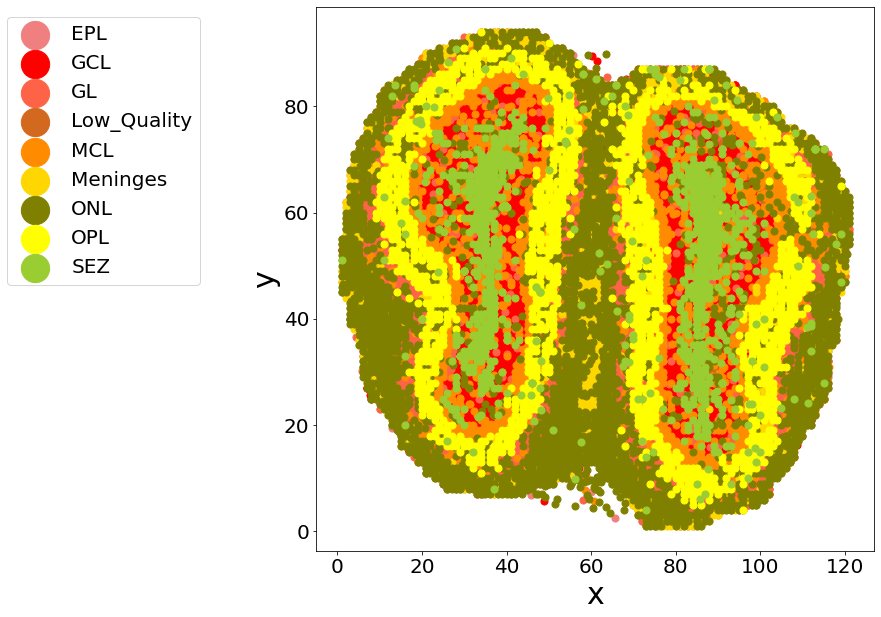

In [17]:
New_Coord1=CA.New_Coord.values
celltype=New_Coord1[:,3]
ul=np.unique(celltype)
import matplotlib.pyplot as plt
colour2=['r','g','black','cyan','blue','purple','yellow','grey']
colour1=['lightcoral','red','tomato','chocolate','darkorange','gold','olive','yellow','yellowgreen','lawngreen','forestgreen','lime',
       'cyan','deepskyblue','dodgerblue','royalblue','blue','blueviolet','purple','fuchsia','hotpink','pink','gray','black','teal']
f, axs= plt.subplots(1,1,figsize=(10,10))
size=50
for i in range(len(ul)):
    axs.scatter(New_Coord1[np.where(celltype==ul[i])[0],0],New_Coord1[np.where(celltype==ul[i])[0],1],c=colour1[i],s=size)

axs.set_xlabel("x",fontsize=30)
axs.set_ylabel("y",fontsize=30)
axs.legend(ul,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(-0.19,1))
axs.tick_params(axis='both', which='major', labelsize=20)

step5:predict 10X Visium

In [18]:
feat_file_10X=dirs+"gtt_input/BGI_SlideV2_10X/10X_mat.csv"
edge_file_10X=dirs+"gtt_input/BGI_SlideV2_10X/10X_edge"+net_cate+str(knn)+".csv"
meta_file_10X=dirs+"gtt_input/BGI_SlideV2_10X/10X_meta.csv"
coord_file_10X=dirs+"gtt_input/BGI_SlideV2_10X/10X_coord.csv"

In [19]:
from sklearn.preprocessing import minmax_scale
knn_pred=6
feat_test=pd.read_csv(feat_file_10X,header=0,index_col=0,sep=SEP)
edge_test=np.loadtxt(edge_file_10X,dtype=str)
meta_test=pd.read_csv(meta_file_10X,header=0,index_col=0)
coord_test=pd.read_csv(coord_file_10X,header=0,index_col=0)
if len(edge_test.shape)<2:
    edge_test=np.array([[i.split(":")[0],i.split(":")[1]] for i in edge])
node_mapping_test=[{j:i for(i,j) in enumerate(feat_test.index)}]
node_mapping_test=node_mapping_test[0]
edge_test=np.array([[node_mapping_test[i[0]],node_mapping_test[i[1]]] for i in edge_test])    
adj_test=process_adj(edge_test,feat_test.shape[0])

x=minmax_scale(feat_test.values,axis=1)
feat_test=pd.DataFrame(x,index=feat_test.index,columns=feat_test.columns)
ub_test=np.unique(meta_test.loc[:,'batch'])
Y_test=np.array([0 if i==ub_test[0] else 1 for i in meta_test.loc[:,'batch']])

In [21]:
# model_file=dirs+"model/AGC_DA_complex"+flags+"_xent_512.pt"
model_file=dirs+"model/SPIRAL"+flags+"_model_"+str(SPII.params.batch_size)+".pt"
SPII.model.load_state_dict(torch.load(model_file))
SPII.model.eval()
all_idx_test=np.arange(feat_test.shape[0])
all_layer_test,all_mapping_test=layer_map(all_idx_test.tolist(),adj_test,len(SPII.params.GSdims))
all_rows_test=adj_test.tolil().rows[all_layer_test[0]]
all_feature_test=torch.Tensor(feat_test.iloc[all_layer_test[0],:].values).float().cuda()
all_embed_test,ae_out_test,clas_out_test,disc_out_test=SPII.model(all_feature_test,all_layer_test,all_mapping_test,all_rows_test,SPII.params.lamda,SPII.de_act,SPII.cl_act)
[ae_embed_test,gs_embed_test,embed_test]=all_embed_test
[x_bar_test,x_test]=ae_out_test
embed_test=embed_test.cpu().detach()
# ######BGI和SlideV2 embed######
embed_1=np.vstack((embed_test[:,SPII.params.znoise_dim:],adata.obsm['spiral']))
cells=np.hstack((feat_test.index,adata.obs_names))
embed_combine=pd.DataFrame(embed_1,index=cells,columns=['SPIRAL-'+str(i) for i in range(embed_1.shape[1])])
# embed_combine.to_csv(dirs+"gtt_output/AGC_embed"+flags+'_'+pred_sample+'_xent_'+str(BS)+"_modify.csv")



ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 28 and the array at index 1 has size 24

In [27]:
feat_combine=pd.concat((SPII.feat,feat_test))
adata_combine=anndata.AnnData(feat_combine)
adata_combine.obsm['spiral']=embed_combine.loc[adata_combine.obs_names,:].values
meta_combine=pd.concat((SPII.meta,meta_test))
adata_combine.obs=meta_combine
coord_combine=pd.concat((coord,coord_test))
adata_combine.obsm['spatial']=coord_combine.loc[adata_combine.obs_names,:].values



step6: KNN prediction

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import euclidean_distances

idx1=np.where(adata_combine.obs['batch']!='10X')[0]
idx2=np.where(adata_combine.obs['batch']=='10X')[0]
embed_train=adata_combine.obsm['spiral'][idx1,:]
embed_test=adata_combine.obsm['spiral'][idx2,:]
clusters=pd.DataFrame(adata.obs['SPIRAL_refine'])

KNC=KNeighborsClassifier(n_neighbors=knn_pred)
KNC.fit(embed_train,clusters.values[:,0])
cluster_pred=KNC.predict(embed_test)
cluster_pred=pd.DataFrame(cluster_pred,index=adata_combine.obs_names[idx2],columns=['pred_clusters'])

dis=euclidean_distances(adata_combine.obsm['spatial'][idx2,:],adata_combine.obsm['spatial'][idx2,:])
refined_pred=refine(np.array(cluster_pred.index), cluster_pred.values[:,0], dis, knn_pred)
refined_pred=pd.DataFrame(refined_pred,index=cluster_pred.index,columns=['SPIRAL_refine'])

clust_combine=pd.concat((pd.DataFrame(adata.obs['SPIRAL_refine']),refined_pred))
adata_combine.obs['SPIRAL']=clust_combine.loc[adata_combine.obs_names,:]
ub=np.unique(adata_combine.obs['batch'])
adata_combine.obs['SPIRAL']=adata_combine.obs['SPIRAL'].astype('category')

/home/tguo/tguo2/miniconda3/envs/stnet/lib/python3.6/site-packages/anndata/_core/anndata.py:1237: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'celltype' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'batch' as categorical


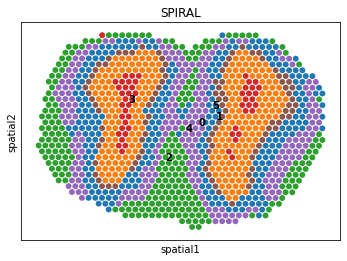

Trying to set attribute `.obs` of view, copying.
... storing 'celltype' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'batch' as categorical


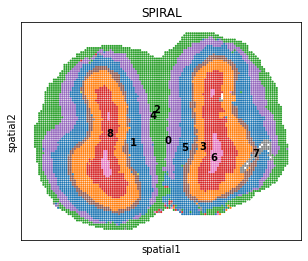

Trying to set attribute `.obs` of view, copying.
... storing 'celltype' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'batch' as categorical


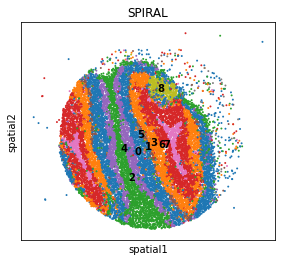

In [29]:
size1=100
size2=1
size3=50
metric='SPIRAL'
adata1=adata_combine[adata_combine.obs['batch']==ub[0],:]
sc.pl.spatial(adata1,color=metric, spot_size=size1,legend_loc='on data')
adata1=adata_combine[adata_combine.obs['batch']==ub[1],:]
sc.pl.spatial(adata1,color=metric, spot_size=size2,legend_loc='on data')
adata1=adata_combine[adata_combine.obs['batch']==ub[2],:]
sc.pl.spatial(adata1,color=metric, spot_size=size3,legend_loc='on data')